# Enzyme Modules

An "enzyme module" is defined as a mechanistic description of a reaction consisting of mass action rate laws for all known reaction steps <cite data-cite="DZK+16">(Du et al., 2016)</cite>. In **MASSpy**, enzyme modules are represented by the `EnzymeModule` object.

To demonstrate the utility of an `EnzymeModule` object and how it aids in constructing mechanistic models of enzyme behavior, an `EnzymeModule` of hexokinase$^{1, 2}$ is constructed and then merged with a model of glycolysis$^{3}$ for verification.

## Constructing Enzyme Modules

In order to construct the `EnzymeModule` of hexokinase, the following information is necessary:

1. The enzyme is a monomer.
2. The enzyme binding of substrates follows a random sequential mechanism.
3. The enzyme experiences product inhibtion and is competitively inhibited by 23DPG when complexed with D-glucose.

Total HEX1 Concentration$^2$: $\text{[HEX1]}_{total} = 24 nM = 0.000024 mM$.

In [1]:
from operator import attrgetter

from mass import MassMetabolite
from mass.enzyme_modules import EnzymeModule
from mass.test import create_test_model

# Load the glycolysis and hemoglobin models, then merge them
glycolysis = create_test_model("Glycolysis")
hemoglobin = create_test_model("Hemoglobin")
glyc_hb = glycolysis.merge(hemoglobin, inplace=False)

The `EnzymeModule` is a subclass of the `MassModel`, meaning that it inherits the methods and behaviors of the `MassModel` object. 
Like a `MassModel`, an `EnzymeModule` object requires a unique identifier in order to be created. Optionally, the `name` and `subsystem` attributes are set during initialization.

In [2]:
HEX1 = EnzymeModule("HEX1", name="Hexokinase (D-glucose:ATP)",
                    subsystem="Glycolysis")

### Defining the enzyme ligands

The ligands that interact with the enzyme (e.g. as the substrates, activators, and inhibitors) are created as `MassMetabolite` objects and added to the model.

In [3]:
glc__D_c = MassMetabolite(
    "glc__D_c",
    name="D-Glucose",
    formula="C6H12O6",
    charge=0,
    compartment="c")
g6p_c = MassMetabolite(
    "g6p_c",
    name="D-Glucose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")
_23dpg_c = MassMetabolite(
    "_23dpg_c", 
    name="2,3-Disphospho-D-glycerate", 
    formula="C3H3O10P2",
    charge=-5,
    compartment="c")
h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c")

HEX1.add_metabolites([glc__D_c, g6p_c, atp_c, adp_c, _23dpg_c, h_c])

Once added to the `EnzymeModule`, ligands can be accessed using the `enzyme_module_ligands` attribute.

In [4]:
HEX1.enzyme_module_ligands

[<MassMetabolite glc__D_c at 0x7fa1ba430690>,
 <MassMetabolite g6p_c at 0x7fa1ba430650>,
 <MassMetabolite atp_c at 0x7fa1ba4306d0>,
 <MassMetabolite adp_c at 0x7fa1ba430710>,
 <MassMetabolite _23dpg_c at 0x7fa1ba430790>,
 <MassMetabolite h_c at 0x7fa1ba4307d0>]

To keep track of the roles played by various ligands in the module, the `enzyme_module_ligands_categorized` attribute is set. The attribute takes a `dict`, with categories as keys and relevant `MassMetabolite` objects as values. Note that an object can be a part of multiple categories.

In [5]:
HEX1.enzyme_module_ligands_categorized =  {
    "substrates": glc__D_c,
    "cofactors": atp_c,
    "inhibitors": _23dpg_c,
    "products": [adp_c, g6p_c, h_c]}
HEX1.enzyme_module_ligands_categorized

[<Group substrates at 0x7fa1ba42c0d0>,
 <Group cofactors at 0x7fa1ba411f90>,
 <Group inhibitors at 0x7fa1ba411a10>,
 <Group products at 0x7fa1b161c110>]

For each category, a `cobra.Group` is created containing the relevant objects. Once set, the attribute returns a `cobra.DictList` that contains the categorized groups. The groups and their members are printed as follows:

In [6]:
for group in HEX1.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

substrates: ['glc__D_c']
cofactors: ['atp_c']
inhibitors: ['_23dpg_c']
products: ['adp_c', 'g6p_c', 'h_c']


### Defining the enzyme module forms

After adding `MassMetabolite` objects of ligands to the model, the various forms of the enzyme must be defined. These forms are represented by `EnzymeModuleForm` objects. 

The `EnzymeModuleForm` object inherits from the `MassMetabolite` and is treated like any other metabolite in the model. However, the `EnzymeModuleForm` object contains the additional `bound_metabolites` attribute to assist in tracking metabolites bound to the enzyme form. 

The `EnzymeModule.make_enzyme_module_form()` method allows for the creation of an `EnzymeModuleForm` object while assigning categories for the  `EnzymeModuleForm` in the process. Using `make_enzyme_module_form()` also adds the species to the module upon creation, accessible via the `EnzymeModule.enzyme_module_forms` attribute.

In [7]:
hex1_c = HEX1.make_enzyme_module_form(
    "hex1_c",
    name="automatic",
    categories="Active",
    compartment="c")

hex1_A_c = HEX1.make_enzyme_module_form(
    "hex1_A_c",  # A stands complexted with ATP
    name="automatic",
    categories="Active",
    bound_metabolites={atp_c: 1},
    compartment="c")

hex1_G_c = HEX1.make_enzyme_module_form(
    "hex1_G_c",  # G stands for complexed with Glucose
    name="automatic",
    categories="Active",
    bound_metabolites={glc__D_c: 1},
    compartment="c")

hex1_AG_c = HEX1.make_enzyme_module_form(
    "hex1_AG_c",
    name="automatic",
    categories="Active",
    bound_metabolites={glc__D_c: 1, atp_c: 1},
    compartment="c")

hex1_G_CI_c = HEX1.make_enzyme_module_form(
    "hex1_G_CI_c",  # CI stands for competitive inhibition
    name="automatic",
    categories="Inhibited",
    bound_metabolites={glc__D_c: 1, _23dpg_c: 1},
    compartment="c")

hex1_A_PI_c = HEX1.make_enzyme_module_form(
    "hex1_A_PI_c",  # PI stands for competitive inhibition
    name="automatic",
    categories="Inhibited",
    bound_metabolites={adp_c: 1},
    compartment="c")

hex1_G_PI_c = HEX1.make_enzyme_module_form(
    "hex1_G_PI_c",  # PI stands for competitive inhibition
    name="automatic",
    categories="Inhibited",
    bound_metabolites={g6p_c: 1},
    compartment="c")

HEX1.enzyme_module_forms

[<EnzymeModuleForm hex1_c at 0x7fa1ba43e190>,
 <EnzymeModuleForm hex1_A_c at 0x7fa1ba43e1d0>,
 <EnzymeModuleForm hex1_G_c at 0x7fa1ba43e310>,
 <EnzymeModuleForm hex1_AG_c at 0x7fa1ba43e5d0>,
 <EnzymeModuleForm hex1_G_CI_c at 0x7fa1ba43e210>,
 <EnzymeModuleForm hex1_A_PI_c at 0x7fa1ba43e890>,
 <EnzymeModuleForm hex1_G_PI_c at 0x7fa1ba43e790>]

The `bound_metabolites` attribute represents the ligands bound to the site(s) of enzyme.

In [8]:
# Print automatically generated names
for enzyme_form in HEX1.enzyme_module_forms:
    print("Bound to sites of {0}:\n{1}\n".format(
        enzyme_form.id, {
            ligand.id: coeff
            for ligand, coeff in enzyme_form.bound_metabolites.items()}))

Bound to sites of hex1_c:
{}

Bound to sites of hex1_A_c:
{'atp_c': 1}

Bound to sites of hex1_G_c:
{'glc__D_c': 1}

Bound to sites of hex1_AG_c:
{'glc__D_c': 1, 'atp_c': 1}

Bound to sites of hex1_G_CI_c:
{'glc__D_c': 1, '_23dpg_c': 1}

Bound to sites of hex1_A_PI_c:
{'adp_c': 1}

Bound to sites of hex1_G_PI_c:
{'g6p_c': 1}



Setting the `bound_metabolites` attribute upon creation allow the `formula` and `charge` attributes of the various forms also to be set while ensuring mass and charge balancing is maintained. Note that the enzyme is represented as a moiety, and the ligands bound to the enzyme are represented in the chemical formula.

In [9]:
# Get the elemental matrix for the enzyme
df = HEX1.get_elemental_matrix(array_type="DataFrame")
# Use iloc to only look at EnzymeModuleForms
df.iloc[:, 6:]

,hex1_c,hex1_A_c,hex1_G_c,hex1_AG_c,hex1_G_CI_c,hex1_A_PI_c,hex1_G_PI_c
C,0.0,10.0,6.0,16.0,9.0,10.0,6.0
H,0.0,12.0,12.0,24.0,15.0,12.0,11.0
O,0.0,13.0,6.0,19.0,16.0,10.0,9.0
P,0.0,3.0,0.0,3.0,2.0,2.0,1.0
N,0.0,5.0,0.0,5.0,0.0,5.0,0.0
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0
q,0.0,-4.0,0.0,-4.0,-5.0,-3.0,-2.0
[HEX],1.0,1.0,1.0,1.0,1.0,1.0,1.0


Setting the `name` argument as "automatic" in the `EnzymeModule.make_enzyme_module_form()` method causes a name for the `EnzymeModuleForm` to be generated based on the metabolites in the `bound_metabolites` attribute.

In [10]:
# Print automatically generated names
for enzyme_form in HEX1.enzyme_module_forms:
    print(enzyme_form.name)

HEX1
HEX1-atp complex
HEX1-glc__D complex
HEX1-glc__D-atp complex
HEX1-glc__D-_23dpg complex
HEX1-adp complex
HEX1-g6p complex


The `categories` argument allows for `EnzymeModuleForm` objects to be placed into `cobra.Group` objects representing those categories. As with the ligands, the categorized enzyme module forms are returned in a `DictList` of `Group` objects by the `enzyme_module_forms_categorized` attribute.

In [11]:
for group in HEX1.enzyme_module_forms_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

Active: ['hex1_AG_c', 'hex1_A_c', 'hex1_G_c', 'hex1_c']
Inhibited: ['hex1_A_PI_c', 'hex1_G_CI_c', 'hex1_G_PI_c']


Alternatively, the `enzyme_module_forms_categorized` attribute can be set using a `dict`:

In [12]:
HEX1.enzyme_module_forms_categorized =  {
    "competitively_inhibited": hex1_G_CI_c}

for group in HEX1.enzyme_module_forms_categorized:
    print("{0}: {1}".format(
        group.id, str(sorted([m.id for m in group.members]))))

Active: ['hex1_AG_c', 'hex1_A_c', 'hex1_G_c', 'hex1_c']
Inhibited: ['hex1_A_PI_c', 'hex1_G_CI_c', 'hex1_G_PI_c']
competitively_inhibited: ['hex1_G_CI_c']


### Defining enzyme module reactions

The next step is to define all of the reaction steps that represent the catalytic mechanism and regulation of the enzyme module. These reactions are represented as `EnzymeModuleReaction` objects. 

The `EnzymeModuleReaction` object inherits from the `MassReaction` and is treated like any other reaction in the model. Like the `make_enzyme_module_form()` method, the `make_enzyme_module_reaction()` method allows for the creation of an `EnzymeModuleReaction` object while assigning categories for the `EnzymeModuleReaction` in the process.

Species that exist in the model can also be added to the reaction by providing a dictionary of metabolites and their stoichiometric coefficients to the `metabolites_to_add` argument.

In [13]:
HEX1_1 = HEX1.make_enzyme_module_reaction(
    "HEX1_1",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="product_inhibition",
    metabolites_to_add={
        "hex1_c": -1,
        "adp_c": -1,
        "hex1_A_PI_c": 1})

HEX1_2 = HEX1.make_enzyme_module_reaction(
    "HEX1_2",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="product_inhibition",
    metabolites_to_add={
        "hex1_c": -1,
        "g6p_c": -1,
        "hex1_G_PI_c": 1})

HEX1_3 = HEX1.make_enzyme_module_reaction(
    "HEX1_3",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="glc__D_c_binding",
    metabolites_to_add={
        "hex1_c": -1,
        "glc__D_c": -1,
        "hex1_G_c": 1})

HEX1_4 = HEX1.make_enzyme_module_reaction(
    "HEX1_4",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="atp_c_binding",
    metabolites_to_add={
        "hex1_c": -1,
        "atp_c": -1,
        "hex1_A_c": 1})

HEX1_5 = HEX1.make_enzyme_module_reaction(
    "HEX1_5",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="competitive_inhibition",
    metabolites_to_add={
        "hex1_G_c": -1,
        "_23dpg_c": -1,
        "hex1_G_CI_c": 1})

HEX1_6 = HEX1.make_enzyme_module_reaction(
    "HEX1_6",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="atp_c_binding",
    metabolites_to_add={
        "hex1_G_c": -1,
        "atp_c": -1,
        "hex1_AG_c": 1})

HEX1_7 = HEX1.make_enzyme_module_reaction(
    "HEX1_7",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="glc__D_c_binding",
    metabolites_to_add={
        "hex1_A_c": -1,
        "glc__D_c": -1,
        "hex1_AG_c": 1})

HEX1_8 = HEX1.make_enzyme_module_reaction(
    "HEX1_8",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="catalyzation",
    metabolites_to_add={
        "hex1_AG_c": -1,
        "hex1_c": 1,
        "adp_c": 1,
        "g6p_c": 1,
        "h_c": 1})

for reaction in HEX1.enzyme_module_reactions:
    print(reaction)

HEX1_1: adp_c + hex1_c <=> hex1_A_PI_c
HEX1_2: g6p_c + hex1_c <=> hex1_G_PI_c
HEX1_3: glc__D_c + hex1_c <=> hex1_G_c
HEX1_4: atp_c + hex1_c <=> hex1_A_c
HEX1_5: _23dpg_c + hex1_G_c <=> hex1_G_CI_c
HEX1_6: atp_c + hex1_G_c <=> hex1_AG_c
HEX1_7: glc__D_c + hex1_A_c <=> hex1_AG_c
HEX1_8: hex1_AG_c <=> adp_c + g6p_c + h_c + hex1_c


The `categories` argument allows for `EnzymeModuleReactions` objects to be placed into `cobra.Group` objects representing those categories. As with the ligands and enzyme forms, a `DictList` of the relevant groups are returned with the `enzyme_module_reactions_categorized` attribute.

In [14]:
HEX1.enzyme_module_reactions_categorized

[<Group product_inhibition at 0x7fa1ba4ab3d0>,
 <Group glc__D_c_binding at 0x7fa1ba4aba90>,
 <Group atp_c_binding at 0x7fa1ba4abe90>,
 <Group competitive_inhibition at 0x7fa1ba4abd50>,
 <Group catalyzation at 0x7fa1ba487cd0>]

#### Unifying rate parameters

For this `EnzymeModule`, the reactions representing glucose binding to the enzyme and ATP binding to the enzyme have the same forward rate and equilibrium constants. Instead of defining the parameter values for each individual reaction, the `unify_rate_parameters()` method can be used to create custom rate laws for the given reactions that all depend on the same rate parameters.

The `unify_rate_parameters()` method takes a list of reactions and an identifier to use for the unified parameter. The `enzyme_prefix` flag can be set to `True` to prefix the new parameter identifier with the identifier of the `EnzymeModule`, ensuring that any existing custom parameters are not overwritten.

In [15]:
for ligand, pid in zip([glc__D_c, atp_c],["G", "A"]):
    # Get the group of reactions corresponding to the ligand
    category = "_".join((ligand.id, "binding"))
    group = HEX1.enzyme_module_reactions_categorized.get_by_id(category)
    
    # Unify the parameters
    HEX1.unify_rate_parameters(
        group.members, new_parameter_id=pid, enzyme_prefix=True)

    # Print the new reaction rates
    print("\n" + category + "\n" + "-" * len(category))
    for reaction in sorted(group.members, key=attrgetter("id")):
        print(reaction.id + ": " + str(reaction.rate))


glc__D_c_binding
----------------
HEX1_3: kf_HEX1_G*(glc__D_c(t)*hex1_c(t) - hex1_G_c(t)/Keq_HEX1_G)
HEX1_7: kf_HEX1_G*(glc__D_c(t)*hex1_A_c(t) - hex1_AG_c(t)/Keq_HEX1_G)

atp_c_binding
-------------
HEX1_4: kf_HEX1_A*(atp_c(t)*hex1_c(t) - hex1_A_c(t)/Keq_HEX1_A)
HEX1_6: kf_HEX1_A*(atp_c(t)*hex1_G_c(t) - hex1_AG_c(t)/Keq_HEX1_A)


## Determining Enzyme Form Concentrations and Rate Constants

The next step is to solve for the steady state concentrations for the various forms of the enzyme symbolically using **SymPy**. Because the numerical values for the dissociation constants have been defined, these equations are solved in terms of the rate constants. The rate constants can be approximated using the total enzyme concentration as a constraint and substituted back into the equations to calculate the numerical values of the steady state concentrations.

In [16]:
from sympy import Eq, Symbol, lambdify, simplify, solveset

from mass import strip_time
from mass.util.matrix import matrix_rank

### Solving steady state concentrations symbolically

To get the symbolic solutions for the individual enzyme forms, the ODEs are first collected in a `dict`. Keys are the enzyme forms, and values are their ODEs with the time dependency stripped via the `strip_time` function.

In [17]:
ode_dict = {
    enzyme_form.id: Eq(strip_time(enzyme_form.ode))
    for enzyme_form in HEX1.enzyme_module_forms}
# Matrix rank of enzyme stoichiometric matrix without substrates
rank = matrix_rank(HEX1.S[6:])
print("Rank Deficiency: {0}".format(len(ode_dict) - rank))

Rank Deficiency: 1


/Users/zhaiman/opt/miniconda3/envs/masspy-dev-py37/lib/python3.7/site-packages/sympy/core/relational.py:490 SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.



Because the stoichiometric matrix (without ligands) has a rank deficiency of one, there is a dependent variable in the system unless another equation is added. Therefore, the completely free enzyme form is treated as the dependent variable, and all of the enzyme forms are solved in terms of the free enzyme form.

In [18]:
enzyme_solutions = {}
for enzyme_form in HEX1.enzyme_module_forms:
    # Skip dependent variable
    if enzyme_form.id == "hex1_c":
        continue
    # Get the ODE for the enzyme form from the ODE dict
    equation = ode_dict[enzyme_form.id]
    # Solve the equation for the enzyme form, substituting 
    # previously found enzyme form solutions into the equation
    solution = solveset(equation.subs(enzyme_solutions),
                        enzyme_form.id)
    # Store the solution
    enzyme_solutions[enzyme_form.id] = list(solution)[0]
    # Substitute the new solution into existing solutions
    enzyme_solutions.update({
        enzyme_form: sol.subs(enzyme_solutions) 
        for enzyme_form, sol in enzyme_solutions.items()})
    
args = set()
for solution in enzyme_solutions.values():
    args.update(solution.atoms(Symbol))

#### Defining the Rate Equation

To make up for the rank deficiency, an additional equation is needed. Typically, the rate of the enzyme is the summation of the rates for the catalyzation reaction step(s) of the enzyme. The `make_enzyme_rate_equation()` method can be used to create the rate equation from a list of reactions. If `use_rates=True`, the rate expressions of the reactions are added together. If `update_enzyme=True`, the rate equation is set as a symbolic expression for the `enzyme_rate_equation` attribute.

In [19]:
# Get the catalyzation reactions
catalyzation_group = HEX1.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation")

HEX1.make_enzyme_rate_equation(catalyzation_group.members,
                               use_rates=True,
                               update_enzyme=True)

print(HEX1.enzyme_rate_equation)

kf_HEX1_8*(Keq_HEX1_8*hex1_AG_c(t) - adp_c(t)*g6p_c(t)*hex1_c(t))/Keq_HEX1_8


With the rate equation defined, the `enzyme_rate_error()` method is used to get the equation as the difference between the flux value and the rate equation.

In [20]:
enzyme_rate_equation = strip_time(HEX1.enzyme_rate_error(use_values=False))
print(enzyme_rate_equation)

v_HEX1 - kf_HEX1_8*(Keq_HEX1_8*hex1_AG_c - adp_c*g6p_c*hex1_c)/Keq_HEX1_8


The solutions for the enzyme forms are substituted into the rate equation, and the equation is solved for the free enzyme form. The solutions are subsequently updated, resulting in symbolic equations that do not depend on any enzyme form.

In [21]:
# Solve for last unknown concentration symbolically
solution = solveset(enzyme_rate_equation.subs(enzyme_solutions),
                    "hex1_c")

# Update solution dictionary with the new solution
enzyme_solutions["hex1_c"] = list(solution)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_form: simplify(solution.subs(enzyme_solutions))
    for enzyme_form, solution in enzyme_solutions.items()}

args = set()
for solution in enzyme_solutions.values():
    args.update(solution.atoms(Symbol))
print(args)

{kf_HEX1_A, Keq_HEX1_2, kf_HEX1_G, glc__D_c, Keq_HEX1_A, Keq_HEX1_1, v_HEX1, Keq_HEX1_G, Keq_HEX1_8, Keq_HEX1_5, _23dpg_c, g6p_c, kf_HEX1_8, adp_c, atp_c}


Numerical values for known quantities are substituted into the equations. For this `EnzymeModule` of Hexokinase, the following dissociation constants are used:

$$\begin{align}
K_{d,\ \text{GLC-D}} &= 0.038\ \text{mM} \\
K_{d,\ \text{ATP}} &= 2.06\ \text{mM} \\
K_{i,\ \text{23DPG}} &= 5.5\ \text{mM} \\
K_{i,\ \text{ADP}} &= 1\ \text{mM} \\
K_{i,\ \text{G6P}} &= 66.67\ \text{mM} \\
\end{align}$$

A value of $K_{\text{HEX1}}= 313.12$ is used for the catalyzation step. Note that the inverse of the dissociation constant is used for reactions that form complexes. 

In [22]:
numerical_values = {
    "Keq_HEX1_1": 1,
    "Keq_HEX1_2": 1 / 66.67,
    "Keq_HEX1_G": 1 / 0.038,  
    "Keq_HEX1_A": 1 / 2.06,
    "Keq_HEX1_5": 1 / 5.5,
    "Keq_HEX1_8": 313.12}
# Update the model with the parameters
HEX1.update_parameters(numerical_values)

The ligand concentrations and the rate for the enzyme are extracted from the merged glycolysis and hemoglobin model.

In [23]:
# Get steady state flux for EnzymeModule
HEX1.enzyme_rate = glyc_hb.reactions.get_by_id("HEX1").steady_state_flux
numerical_values[HEX1.enzyme_flux_symbol_str] = HEX1.enzyme_rate

# Get the ligand concentrations
for met in HEX1.enzyme_module_ligands:
    concentration = glyc_hb.metabolites.get_by_id(met.id).initial_condition
    # Set the ligand initial condition and add to numercal values dictionary
    met.initial_condition = concentration
    numerical_values[met.id] = concentration

The numerical values are substituted into the symbolic equations, resulting in the steady state concentrations that depend only on the rate constants.

In [24]:
enzyme_solutions = {
    enzyme_form: simplify(sol.subs(numerical_values))
    for enzyme_form, sol in enzyme_solutions.items()}

args = set()
for solution in enzyme_solutions.values():
    args.update(solution.atoms(Symbol))
print(args)

{kf_HEX1_G, kf_HEX1_8, kf_HEX1_A}


### Approximating Rate Constants

To determine the set of rate constants for the enzyme module, the absolute error between the total hexokinase concentration value (found in literature) and the computed hexokinase concentration is minimized. For this example, the `minimize()` function of the **SciPy** package is utilized to find a feasible set of rate constants. 

In [25]:
from scipy.optimize import minimize

The objective function for the minimization is first made symbolically. The `enzyme_total_symbol_str` property can be used to represent the total enzyme concentration, while the `enzyme_concentration_total_equation` property creates a symbolic expression for the sum of all enzyme forms.

In [26]:
enzyme_total_error = abs(
    Symbol(HEX1.enzyme_total_symbol_str)
    - strip_time(HEX1.enzyme_concentration_total_equation))
print(enzyme_total_error)

Abs(-HEX1_Total + hex1_AG_c + hex1_A_PI_c + hex1_A_c + hex1_G_CI_c + hex1_G_PI_c + hex1_G_c + hex1_c)


The `enzyme_concentration_total` attribute stores the total amount of enzyme in the model and substituted into the expression. The total HEX1 concentration is $24 * 10^{-6} \text{mM}$.

In [27]:
HEX1.enzyme_concentration_total = 24e-6
enzyme_total_error = enzyme_total_error.subs({
    HEX1.enzyme_total_symbol_str: HEX1.enzyme_concentration_total})
print(enzyme_total_error)

Abs(hex1_AG_c + hex1_A_PI_c + hex1_A_c + hex1_G_CI_c + hex1_G_PI_c + hex1_G_c + hex1_c - 2.4e-5)


Finally, the symbolic equations for the enzyme forms are substituted into the enzyme total error equation, resulting in an expression that represents the objective function with the only unknown variables being rate constants. The `lambdify()` function of the **SymPy** package converts the symbolic objective into a lambda function that can be used with the `minimize()` function of **SciPy**.

In [28]:
enzyme_total_error = simplify(enzyme_total_error.subs(enzyme_solutions))

# Sort the arguments to ensure input format remains consistent
args = sorted(list(map(str, args)))
# Use lambdify to make objective function as a lambda function
obj_fun = lambda x: lambdify(args, enzyme_total_error)(*x)

The `minimize()` function is now used to approximate the rate constants. The optimization problems for enzyme rate constants are typically nonlinear, and require nonlinear optimization routines to find feasible solutions.

In [29]:
# Minimize the objective function, initial guess based on publication values
initial_guess = [1e8, 9376585, 52001]
variable_bounds = ((0, 1e9), (0, 1e9), (0, 1e9))
solution = minimize(obj_fun, x0=initial_guess,
                    method="trust-constr",
                    bounds=variable_bounds)
# Map solution array to variables
rate_constants = dict(zip(args, solution.x))
print(rate_constants)

{'kf_HEX1_8': 100000000.0025878, 'kf_HEX1_A': 9376585.030755484, 'kf_HEX1_G': 52006.59981223971}


Because the rate constants associated with the inhibition of the enzyme forms are not necessary for computing the concentrations, a rapid binding assumption is made for the inhibition reactions. Therefore, a large number is set for the rate constants. The parameters are set using the `update_parameters()` method.

In [30]:
rate_constants["kf_HEX1_1"] = 1e6
rate_constants["kf_HEX1_2"] = 1e6
rate_constants["kf_HEX1_5"] = 1e6
HEX1.update_parameters(rate_constants)

### Calculating numerical values for concentrations

Once the rate constants have been estimated, they are substituted back into the symbolic concentration equations in order to obtain their numerical values.

In [31]:
for enzyme_form, solution in enzyme_solutions.items():
    # Get the enzyme form object, determine the steady state concentration
    enzyme_form = HEX1.enzyme_module_forms.get_by_id(enzyme_form)
    enzyme_form.initial_condition = float(solution.subs(rate_constants))
    print("{0}: {1:e}".format(enzyme_form.id,
                              enzyme_form.initial_condition))

hex1_A_c: 9.401421e-06
hex1_G_c: 5.718872e-08
hex1_AG_c: 1.174630e-08
hex1_G_CI_c: 3.223364e-08
hex1_A_PI_c: 3.519706e-06
hex1_G_PI_c: 8.847367e-09
hex1_c: 1.213692e-05


#### Error values

As a quality assurance check, the `enzyme_concentration_total_error()` method can be used to get the error between the `enzyme_concentration_total` attribute and the sum of the enzyme form concentrations. A positive value indicates the `enzyme_concentration_total` attribute is greater than the sum of the individual enzyme form concentrations that were computed.

In [32]:
print("Total Enzyme Concentration Error: {0}".format(
    HEX1.enzyme_concentration_total_error(use_values=True)))

Total Enzyme Concentration Error: -1.1680622689093244e-06


Similarly, the error between the `enzyme_rate` attribute and the computed value from the `enzyme_rate_equation` can be also checked using the `enzyme_rate_error()` method, in which a positive value indicates that the `enzyme_rate` attribute is greater than the value computed when using the rate equation.

In [33]:
print("Enzyme Rate Error: {0}".format(
    HEX1.enzyme_rate_error(use_values=True)))

Enzyme Rate Error: 4.440892098500626e-16


## Adding EnzymeModules to Models

With the `EnzymeModule` built, it can be integrated into a larger network and simulated. To add an `EnzymeModule` to an existing `MassModel`, the `merge()` method is used. After merging, the `remove_reactions()` method is used to remove the reaction replaced with the enzyme module. The `EnzymeModule` should always be merged into the `MassModel` as demonstrated below:

In [34]:
glyc_hb_HEX1 = glyc_hb.merge(HEX1, inplace=False)
glyc_hb_HEX1.remove_reactions([
    glyc_hb_HEX1.reactions.get_by_id("HEX1")])

All objects, numerical values, and certain attributes of the `EnzymeModule` are transferred into the `MassModel` upon merging. This includes all enzyme forms, reactions steps, initial conditions, rate parameters, and category groups.

In [35]:
glyc_hb_HEX1

Name,Glycolysis_Hemoglobin_HEX1
Memory address,0x07fa1b91a4050
Stoichiometric Matrix,35x37
Matrix Rank,32
Number of metabolites,35
Initial conditions defined,35/35
Number of reactions,37
Number of genes,0
Number of enzyme modules,1
Number of groups,12
Objective expression,0


### The EnzymeModuleDict object

During the merge process, an `EnzymeModuleDict` is created from the `EnzymeModule` and added to the `MassModel.enzyme_modules` attribute.

In [36]:
print(glyc_hb_HEX1.enzyme_modules)
HEX1_dict = glyc_hb_HEX1.enzyme_modules.get_by_id("HEX1")
HEX1_dict

[<EnzymeModuleDict HEX1 at 0x7fa1ba6418c0>]


Name,HEX1
Memory address,0x07fa1ba6418c0
Stoichiometric Matrix,13x8
Matrix Rank,7
Subsystem,Glycolysis
Number of Ligands,6
Number of EnzymeForms,7
Number of EnzymeModuleReactions,8
Enzyme Concentration Total,2.4e-05
Enzyme Net Flux,1.12


The `EnzymeModuleDict` inherits from an `OrderedDict`, thereby inheriting ordered dictionary methods such as `keys()`:

In [37]:
print("\n".join(HEX1_dict.keys()))

id
name
subsystem
enzyme_module_ligands
enzyme_module_forms
enzyme_module_reactions
enzyme_module_ligands_categorized
enzyme_module_forms_categorized
enzyme_module_reactions_categorized
enzyme_concentration_total
enzyme_rate
enzyme_concentration_total_equation
enzyme_rate_equation
S
model


The `EnzymeModuleDict` stores several of the enzyme-specific attributes so that they are still accessible after integrating the enzyme module into a larger network. The keys of the `EnzymeModuleDict`  also can be treated as attribute accessors:

In [38]:
print("Enzyme Rate:\n{0} = {1}".format(
    HEX1_dict["enzyme_rate"],       # Returned using dict key
    HEX1_dict.enzyme_rate_equation  # Returned using attribute accessor
))

Enzyme Rate:
1.12 = kf_HEX1_8*(Keq_HEX1_8*hex1_AG_c(t) - adp_c(t)*g6p_c(t)*hex1_c(t))/Keq_HEX1_8


### Steady State Validation
The last step is to ensure that a steady state is reached with the completed enzyme module within a larger network context.

In [39]:
import matplotlib.pyplot as plt

from mass import Simulation
from mass.visualization import plot_time_profile

Here, the model is simulated, and the enzyme's ability to reach steady state is graphically verified: 

Successfully loaded MassModel 'Glycolysis_Hemoglobin_HEX1' into RoadRunner.


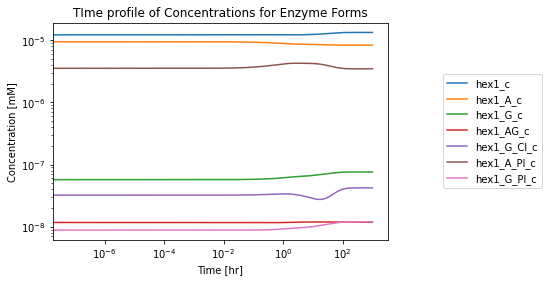

In [40]:
# Setup simulation object
sim = Simulation(glyc_hb_HEX1, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(
    glyc_hb_HEX1, time=(0, 1e3, 1e4 + 1))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
plot_time_profile(
    conc_sol, observable=HEX1_dict.enzyme_module_forms, ax=ax,
    legend="right outside", plot_function="loglog",
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title="TIme profile of Concentrations for Enzyme Forms");

The plot shows that the enzyme can reach a steady state when integrated into a larger network, meaning the enzyme module that represents hexokinase in this system is complete!

## Additional Examples
For additional examples of analyzing and visualizing systems with enzyme modules, see the following: 

* [Visualizing Catalytic Potentials of Glycolytic Regulatory Kinases: Part 1](./advanced_visualization/catalytic_potential_visualizations_p1.ipynb)
* [Visualizing Catalytic Potentials of Glycolytic Regulatory Kinases: Part 2](./advanced_visualization/catalytic_potential_visualizations_p2.ipynb)

$^1$ Procedure outlined in <cite data-cite="DZK+16">Du et al., 2016</cite>

$^2$ Hexokinase based on <cite data-cite="YAHP18">Yurkovich et al., 2018</cite>, <cite data-cite="DZK+16">Du et al., 2016</cite>, and <cite data-cite="MK99">Mulquiney and Kuchel, 1999.</cite>

$^3$ Glycolysis model based on <cite data-cite="YAHP18">Yurkovich et al., 2018</cite> and Chapter 10 of <cite data-cite="Pal11">Systems Biology: Simulation of Dynamic Network States</cite>